In [343]:
import numpy as np
import scipy.stats as st
import scipy.optimize as op

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

figsize = [3, 2.25]
alpha = 0.05
n_iter = 1000000

### Calculation functions

In [344]:
def get_lift_dist(reach, true_lift, conv_ctrl, ctrl_scale_factor, n_iter=1000000):
    
    lam_C_c = conv_ctrl
    lam_C_t = ctrl_scale_factor * lam_C_c * (1 + true_lift * reach)

    C_t = np.random.poisson(lam_C_t, n_iter)
    C_c = np.random.poisson(lam_C_c, n_iter)

    R_c = C_c * reach
    
    L = (C_t - ctrl_scale_factor * C_c) / (ctrl_scale_factor * R_c)
    
    return L

def get_crit_val(reach, conv_ctrl, ctrl_scale_factor, alpha=0.05, n_iter=1000000):
    
    # Get the distribution of L under H0.  True lift = 0
    L = get_lift_dist(reach, 0, conv_ctrl, ctrl_scale_factor, n_iter)
    
    crit_val = np.percentile(L, 100*(1 - alpha))
    
    return crit_val

def get_lift_study_power(reach, min_lift, conv_ctrl, ctrl_scale_factor, alpha=0.05, n_iter=1000000):
    
    crit_val = get_crit_val(reach, conv_ctrl, ctrl_scale_factor, alpha, n_iter)
    
    # Get the distribution of L under H1
    L = get_lift_dist(reach, min_lift, conv_ctrl, ctrl_scale_factor, n_iter)
    
    power = (100 - st.percentileofscore(L, crit_val)) / 100
    
    return power

def lift_study_power_helper(conv_ctrl, *args):
    reach, min_lift, alpha, min_power, ctrl_scale_factor, n_iter = args
    power = get_lift_study_power(reach, min_lift, conv_ctrl, ctrl_scale_factor, alpha, n_iter)
    
    return power - min_power

def get_min_conv_ctrl(reach, min_lift, ctrl_scale_factor, alpha=0.05, power=0.8, n_iter=1000000):
    
    a = 100
    b = 50e6
    xtol = 10
    rtol = 0.01
    
    conv_ctrl = op.bisect(lift_study_power_helper, a, b, 
                          args=(reach, min_lift, alpha, power, ctrl_scale_factor, n_iter), 
                          xtol=xtol, rtol=rtol)
    
    return conv_ctrl

def get_lift_diff_power(reach, lift_a, min_lift_uplift, conv_ctrl_a, ctrl_scale_factor, alpha=0.05, n_iter=1000000):
    
    # Calculate the critical value under H0
    L_a = get_lift_dist(reach, lift_a, conv_ctrl_a, ctrl_scale_factor, n_iter)
    L_b = get_lift_dist(reach, lift_a, conv_ctrl_a, ctrl_scale_factor, n_iter)
    
    L_ab = L_b - L_a
    
    crit_val = np.percentile(L_ab, 100*(1-alpha))
    
    # Calculate the test power under H1
    # NOTE: WE ARE ASSUMING THE CONTROLS IN A AND B HAVE THE SAME CONVERSION RATE WHICH IS NOT THE CASE
    # - HOWEVER IT'S THE ONLY ESTIMATE WE HAVE
    L_b = get_lift_dist(reach, lift_a + min_lift_uplift, conv_ctrl_a, ctrl_scale_factor, n_iter)
    
    L_ab = L_b - L_a
    
    power = (100 - st.percentileofscore(L_ab, crit_val)) / 100
    
    return power

def lift_diff_power_helper(conv_ctrl_a, *args):
    reach, lift_a, min_lift_uplift, ctrl_scale_factor, min_power, alpha, n_iter = args
    power = get_lift_diff_power(reach, lift_a, min_lift_uplift, conv_ctrl_a, ctrl_scale_factor, alpha, n_iter)
    
    return power - min_power

def get_min_conv_ctrl_a(reach, lift_a, min_lift_uplift, ctrl_scale_factor, alpha=0.05, power=0.8, n_iter=1000000):
    
    a = 100
    b = 50e8
    xtol = 10
    rtol = 0.01
    
    conv_ctrl_a = op.bisect(lift_diff_power_helper, a, b, 
                          args=(reach, lift_a, min_lift_uplift, ctrl_scale_factor, power, alpha, n_iter), 
                          xtol=xtol, rtol=rtol)
    
    return conv_ctrl_a

### Plotting functions

In [345]:
########################
# Single cell lift study

def plot_power_by_sample_size(ax, reach, min_lifts, convs_ctrl, ctrl_scale_factor, alpha=0.05, n_iter=1000000):
    
    for min_lift in min_lifts:
        powers = []
        for conv in convs_ctrl:
            powers.append(100 * get_lift_study_power(reach, min_lift, conv, ctrl_scale_factor, alpha, n_iter))

        ax.plot(convs_ctrl, powers, label='{:.0f}%'.format(100 * min_lift))

    ax.set_xlim([0,max(convs_reached_ctrl)])
    ax.set_ylim([0, 100])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: thousands_tick_formatter(x, p)))
    ax.set_xlabel('Conversions in control')
    ax.set_ylabel('Power (%)')
    ax.legend(loc='lower right', title='$L_m$')
    
def plot_power_by_reach(ax, reaches, min_lifts, conv_ctrl, ctrl_scale_factor, alpha=0.05, n_iter=1000000):
    """Vary the reach holding the total audience size constant"""
    
    for min_lift in min_lifts:
        powers = []
        for reach in reaches:
            powers.append(100 * get_lift_study_power(reach, min_lift, conv_ctrl, ctrl_scale_factor, 
                                                     alpha, n_iter))

        ax.plot(100 * reaches, powers, label='{:.0f}%'.format(100 * min_lift))

    ax.set_xlim([0,100])
    ax.set_ylim([0, 100])
    ax.set_xlabel('Reach (%)')
    ax.set_ylabel('Power (%)')
    #ax.legend(loc='upper right', title='$L_m$')
    
def plot_power_by_ctrl_scale_factor(ax, reach, min_lifts, conv_ctrl_at_50, ctrl_splits, 
                                    alpha=0.05, n_iter=1000000):
    """Vary the fraction of audience in the control group"""
    
    for min_lift in min_lifts:
        powers = []
        for split in ctrl_splits:
            s = (1 - split) / split
            conv = split * conv_ctrl_at_50 / 0.5
            powers.append(100 * get_lift_study_power(reach, min_lift, conv, s, 
                                                     alpha, n_iter))

        ax.plot(ctrl_splits, powers, label='{:.0f}%'.format(100 * min_lift))

    ax.set_xlim([0,1])
    ax.set_ylim([0, 100])
    ax.set_xlabel('Fraction of audience in control group')
    ax.set_ylabel('Power (%)')
    #ax.legend(loc='upper right', title='$L_m$')

#######################
# Multi-cell lift study

def plot_power_by_sample_size_mc(ax, reach, lift_a, min_lift_uplifts, convs_ctrl_a, ctrl_scale_factor, 
                                 alpha=0.05, n_iter=1000000):
    
    for min_lift_uplift in min_lift_uplifts:
        powers = []
        for conv in convs_ctrl_a:
            powers.append(100 * get_lift_diff_power(reach, lift_a, min_lift_uplift, conv, ctrl_scale_factor, 
                                                    alpha, n_iter))
            

        ax.plot(convs_ctrl_a, powers, label='{:.0f}%'.format(100 * min_lift_uplift))

    ax.set_xlim([0,max(convs_ctrl_a)])
    ax.set_ylim([0, 100])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: thousands_tick_formatter(x, p)))
    ax.set_xlabel('Conversions in cell $A$ control')
    ax.set_ylabel('Power (%)')
    ax.legend(loc='lower right', title='$D_m$')
    
def thousands_tick_formatter(x, p):
    if x >= 1000:
        x = str(int(x / 1000)) + 'k'
    else:
        x = int(x)
    return x

## Single cell lift study

### Power visualisation

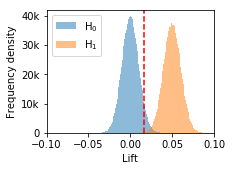

In [346]:
reach = 1
true_lift = 0.05
conv_ctrl = 20000
split = 0.5
ctrl_scale_factor = (1 - split) / split

h0_dist = get_lift_dist(reach, 0, conv_ctrl, ctrl_scale_factor)
h1_dist = get_lift_dist(reach, true_lift, conv_ctrl, ctrl_scale_factor)

crit_val = get_crit_val(reach, conv_ctrl, ctrl_scale_factor, alpha=alpha)

power = (100 - st.percentileofscore(h1_dist, crit_val)) / 100

fig = plt.figure(figsize=figsize)
ax = fig.gca()

ax.hist(h0_dist, bins=100, label='$\mathrm{H_0}$', alpha=0.5)
ax.hist(h1_dist, bins=100, label='$\mathrm{H_1}$', alpha=0.5)
plt.axvline(crit_val, color='r', ls='--')
ax.set_xlim([-0.1,0.1])
plt.draw()

xlabels = [x.get_text() for x in ax.get_xticklabels()]
xlocs = list(ax.get_xticks())

labels.append(r'$c$')
locs.append(crit_val)

ax.set_xticklabels(xlabels)
ax.set_xticks(xlocs)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: thousands_tick_formatter(x, p)))
ax.legend()
ax.set_xlabel('Lift')
ax.set_ylabel('Frequency density')

plt.savefig('img/single_cell_dist.pdf', bbox_inches='tight');

In [347]:
power

0.99947100000000011

### Power vs audience size

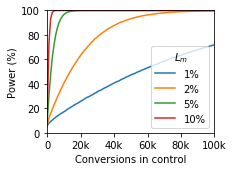

In [348]:
reach = 1
min_lifts = [0.01, 0.02, 0.05, 0.1]
convs_ctrl = np.linspace(100, 100000, 100)
ctrl_scale_factor = 1

fig = plt.figure(figsize=figsize)
ax = fig.gca()

plot_power_by_sample_size(ax, reach, min_lifts, convs_ctrl, ctrl_scale_factor, alpha, n_iter)

plt.savefig('img/single_cell_power_vs_conv.pdf', bbox_inches='tight')

### Power vs reach

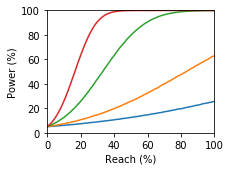

In [349]:
reaches = np.linspace(0.001, 1, 100)
min_lifts = [0.01, 0.02, 0.05, 0.1]
conv_ctrl = 20000
ctrl_scale_factor = 1

fig = plt.figure(figsize=figsize)
ax = fig.gca()

plot_power_by_reach(ax, reaches, min_lifts, conv_ctrl, ctrl_scale_factor, alpha, n_iter)

plt.savefig('img/single_cell_power_vs_reach.pdf', bbox_inches='tight')

### Power vs control/test split

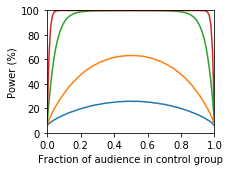

In [350]:
reach = 1
min_lifts = [0.01, 0.02, 0.05, 0.1]
conv_ctrl = 20000
ctrl_splits = np.linspace(0.001, 0.999, 100)

fig = plt.figure(figsize=figsize)
ax = fig.gca()

plot_power_by_ctrl_scale_factor(ax, reach, min_lifts, conv_ctrl, ctrl_splits, alpha, n_iter)

plt.savefig('img/single_cell_power_vs_split.pdf', bbox_inches='tight')

### Minimum sample size

In [351]:
reach = 1
ctrl_scale_factor = 1

for min_lift in [0.1, 0.05, 0.02, 0.01]:
    min_conv_ctrl = get_min_conv_ctrl(reach, min_lift, ctrl_scale_factor)
    N = 2 * min_conv_ctrl / 0.05
    print('{:.0f}%: {:.0f}, {:.0f}'.format(100 * min_lift, min_conv_ctrl, N))

10%: 1328, 53114
5%: 5202, 208086
2%: 31571, 1262848
1%: 124459, 4978355


## Multi-cell lift study

### Power visualisation

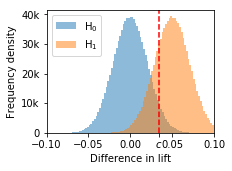

In [352]:
reach = 1
lift_a = 0.05
min_lift_uplift = 0.05 # NOTE: This is the absolute uplift
conv_ctrl_a = 10000
split = 0.5
ctrl_scale_factor = (1 - split) / split

L_a = get_lift_dist(reach, lift_a, conv_ctrl_a, ctrl_scale_factor)
L_b = get_lift_dist(reach, lift_a, conv_ctrl_a, ctrl_scale_factor)

L_ab_h0 = (L_b - L_a)

crit_val = np.percentile(L_ab_h0, 100*(1-alpha))

# Calculate the test power under H1
# NOTE: WE ARE ASSUMING THE CONTROLS IN A AND B HAVE THE SAME CONVERSION RATE WHICH IS NOT THE CASE
# - HOWEVER IT'S THE ONLY ESTIMATE WE HAVE
L_b = get_lift_dist(reach, lift_a + min_lift_uplift, conv_ctrl_a, ctrl_scale_factor)

L_ab_h1 = (L_b - L_a)

power = (100 - st.percentileofscore(L_ab_h1, crit_val)) / 100

fig = plt.figure(figsize=figsize)
ax = fig.gca()

ax.hist(L_ab_h0, bins=100, label='$\mathrm{H_0}$', alpha=0.5)
ax.hist(L_ab_h1, bins=100, label='$\mathrm{H_1}$', alpha=0.5)
plt.axvline(crit_val, color='r', ls='--')
ax.set_xlim([-0.1,0.1])
plt.draw()

labels = [x.get_text() for x in ax.get_xticklabels()]
locs = list(ax.get_xticks())

labels.append(r'$c$')
locs.append(crit_val)
ax.set_xticklabels(labels)
ax.set_xticks(locs)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: thousands_tick_formatter(x, p)))
ax.legend()
ax.set_xlabel('Difference in lift')
ax.set_ylabel('Frequency density')

plt.savefig('img/multi_cell_dist.pdf', bbox_inches='tight');

In [353]:
power

0.77393000000000001

### Power vs audience size

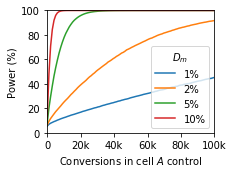

In [354]:
reach = 1
lift_a = 0.05
min_lift_uplifts = [0.01, 0.02, 0.05, 0.1]
convs_ctrl_a = np.linspace(100, 100000, 100)
ctrl_scale_factor = 1

fig = plt.figure(figsize=figsize)
ax = fig.gca()

plot_power_by_sample_size_mc(ax, reach, lift_a, min_lift_uplifts, convs_ctrl_a, ctrl_scale_factor, alpha, n_iter)

plt.savefig('img/multi_cell_power_vs_conv.pdf', bbox_inches='tight')

### Minimum sample size

In [355]:
reach = 1
lift_a = 0.05
ctrl_scale_factor = 1

for min_lift_uplift in [0.1, 0.05, 0.02, 0.01]:
    min_conv_ctrl_a = get_min_conv_ctrl_a(reach, lift_a, min_lift_uplift, ctrl_scale_factor)
    N = 4 * min_conv_ctrl_a / 0.05
    print('{:.0f}%: {:.0f}, {:.0f}'.format(100 * min_lift_uplift, min_conv_ctrl_a, N))

10%: 2745, 219596
5%: 10754, 860346
2%: 67453, 5396260
1%: 269513, 21561039
